In [1]:
import pandas as pd
import numpy as np
import math
import chart_studio.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, mean_squared_error, f1_score, matthews_corrcoef, classification_report, roc_curve, auc



In [2]:
# Load model from file
#xnn_dir = '/home/kimm/article-information-2019/data/xnn_output/simulation_results/'
#xnn_dir = '/Users/kmontgomery/Documents/git/article-information-2019/data/xnn_output/simulation_results/'
xnn_dir = '/Users/phall/workspace/article-information-2019/data/xnn_output/simulation_results/'

label = "sim_final"

filename = 'main_20000_' + label + '.csv'

TEST = pd.read_csv(xnn_dir + filename)

Feature_names = ['binary1', 'binary2', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4', 
                 'fried1_std', 'fried2_std', 'fried3_std', 'fried4_std', 'fried5_std']

In [3]:
TEST.columns

Index(['Unnamed: 0', 'binary1', 'binary2', 'ctrl_class1', 'ctrl_class2',
       'fold', 'intercept', 'latent_no_noise', 'latent_with_noise',
       'logistic_noise', 'outcome', 'outcome_no_noise', 'prot_class1',
       'prot_class2', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4',
       'fried1_std', 'fried2_std', 'fried3_std', 'fried4_std', 'fried5_std',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')

In [4]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y 
        and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values.
        
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y)          # column for predicted decisions
    eps = 1e-20                    # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

# calculate and display recall and precision
#prauc_frame = get_prauc(test_yhat, y, yhat)
prauc_frame = get_prauc(TEST, 'outcome', '0')
prauc_frame.style.set_caption('Recall and Precision')

,cutoff,recall,precision,f1
0,0,1,0.49935,0.666089
1,0.01,1,0.500978,0.667536
2,0.02,0.9999,0.506005,0.67196
3,0.03,0.998698,0.51217,0.677099
4,0.04,0.997597,0.518151,0.682047
5,0.05,0.996796,0.524361,0.687215
6,0.06,0.995594,0.531512,0.693037
7,0.07,0.993792,0.538174,0.698231
8,0.08,0.991689,0.544206,0.70276
9,0.09,0.989586,0.551045,0.707901


In [5]:
# Calculate the best F1 threshold

xnn_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # value associated w/ index of max. F1
print('Best F1 threshold: %.2f' % xnn_cut)

Best F1 threshold: 0.38


In [6]:
# Calculate test statistics
Prediction = list(TEST['0'])
Classification = list(TEST['0'].apply(lambda x: int(x >= 0.38)))
Actual = list(TEST['outcome'].apply(int))

test_statistics = {}

#classification_rep = classification_report(Actual, Classification, output_dict=True)
classification_rep = classification_report(Actual, Classification, digits=3)

test_statistics['AUC'] = roc_auc_score(Actual, Prediction)
test_statistics['accuracy_score'] = accuracy_score(Actual, Classification)
test_statistics['log_loss'] = log_loss(Actual, Prediction)
test_statistics['rmse'] = math.sqrt(mean_squared_error(Actual, Prediction))
test_statistics['mcc'] = matthews_corrcoef(Actual, Classification)
#test_statistics['precision'] = classification_rep[1]['precision']
#test_statistics['sensitivity'] = classification_rep[1]['recall']
test_statistics['F1'] = f1_score(Actual, Classification)

print(test_statistics)

{'AUC': 0.8509608031237572, 'accuracy_score': 0.75765, 'log_loss': 0.47880798822311327, 'rmse': 0.39671323382398566, 'mcc': 0.5282898569758259, 'F1': 0.7813416339603916}


In [7]:
# recall of the positive class is also known as “sensitivity”
# recall of the negative class is “specificity”
print(classification_rep)

             precision    recall  f1-score   support

          0      0.830     0.648     0.728     10013
          1      0.711     0.867     0.781      9987

avg / total      0.771     0.758     0.755     20000



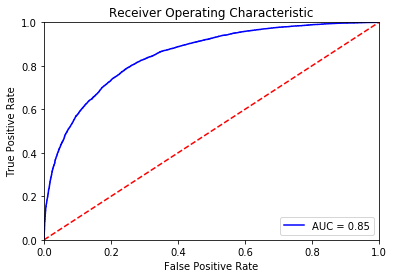

In [7]:
fpr, tpr, threshold = roc_curve(Actual, Prediction)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [8]:
# Shapley and prediction matrix

SHAPLEY = TEST[[str(col) for col in range(0, 14)]].copy()

# Take the absolute value of the Shapley values

for col in range(1, 14):
    SHAPLEY[str(col)] = SHAPLEY[str(col)].apply(abs)
    
Global_Shapley_Feature_Importance = SHAPLEY[[str(col) for col in range(1, 14)]].mean()
Global_Shapley_Feature_Importance.index = Feature_names + ['Intercept']
## Global_Shapley_Feature_Importance = Global_Shapley_Feature_Importance.sort_values(ascending=False)

In [9]:
print("Global Shapley Feature Importance")

Global_Shapley_Feature_Importance 


Global Shapley Feature Importance


binary1       0.035411
binary2       0.033024
cat1_0        0.008421
cat1_1        0.044746
cat1_2        0.054404
cat1_3        0.051680
cat1_4        0.013794
fried1_std    0.201394
fried2_std    0.210497
fried3_std    0.089225
fried4_std    0.179631
fried5_std    0.087975
Intercept     0.535732
dtype: float64

In [103]:
Feature_importance = pd.DataFrame(Global_Shapley_Feature_Importance)

In [104]:
SHAPLEY.iloc[0:4,]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.201806,0.035829,0.022996,0.002511,0.027053,0.123897,0.034448,0.009958,0.256220,0.156339,0.09665,0.218874,0.074805,0.535732
1,0.062930,0.031351,0.017718,0.005402,0.025019,0.026105,0.057560,0.005454,0.347382,0.197101,0.08208,0.293846,0.018926,0.535732
2,0.156866,0.037858,0.076471,0.003675,0.027641,0.111002,0.035966,0.008697,0.259329,0.051023,0.05482,0.031532,0.028949,0.535732
3,0.456577,0.043354,0.092412,0.011932,0.038765,0.039233,0.099819,0.007529,0.437200,0.375689,0.21500,0.317492,0.146801,0.535732


In [105]:
# Find the average shapley value for each quintile

SHAPLEY = SHAPLEY.sort_values('0')
len_Quintile=int(len(SHAPLEY)/5)

quintile_dict = {}
for quintile in range(1, 6):
    if quintile == 5:
        QUINTILE = SHAPLEY.iloc[(len_Quintile * (quintile - 1)):, 1:14].copy()
    else:
        QUINTILE = SHAPLEY.iloc[(len_Quintile * (quintile - 1)):(len_Quintile*quintile), 1:14].copy()
        
    QUINTILE = QUINTILE.mean()
    QUINTILE.index = Feature_names + ['Intercept']
    # QUINTILE = QUINTILE.sort_values(ascending=False)
    quintile_dict[quintile] = QUINTILE
    Feature_importance['Quintile '+str(quintile)] = QUINTILE
    print(quintile_dict[quintile])



binary1       0.030178
binary2       0.027294
cat1_0        0.007271
cat1_1        0.031961
cat1_2        0.058921
cat1_3        0.037941
cat1_4        0.014440
fried1_std    0.202560
fried2_std    0.193825
fried3_std    0.074172
fried4_std    0.195048
fried5_std    0.085060
Intercept     0.535732
dtype: float64
binary1       0.039443
binary2       0.036219
cat1_0        0.009738
cat1_1        0.046830
cat1_2        0.064423
cat1_3        0.053775
cat1_4        0.016512
fried1_std    0.234380
fried2_std    0.241120
fried3_std    0.096600
fried4_std    0.186208
fried5_std    0.098547
Intercept     0.535732
dtype: float64
binary1       0.041671
binary2       0.038579
cat1_0        0.010122
cat1_1        0.052149
cat1_2        0.061941
cat1_3        0.059715
cat1_4        0.015754
fried1_std    0.233370
fried2_std    0.254649
fried3_std    0.105224
fried4_std    0.187764
fried5_std    0.099137
Intercept     0.535732
dtype: float64
binary1       0.037967
binary2       0.035081
cat1_0      

In [124]:
Feature_importance = Feature_importance.rename(columns={"0": "Global Feature_Importance"})

Feature_importance.to_csv(xnn_dir + "Results_simulation_Feature_Importance.csv")

Feature_importance

,0,Quintile 1,Quintile 2,Quintile 3,Quintile 4,Quintile 5
binary1,0.035411,0.030178,0.039443,0.041671,0.037967,0.027796
binary2,0.033024,0.027294,0.036219,0.038579,0.035081,0.027946
cat1_0,0.008421,0.007271,0.009738,0.010122,0.009020,0.005957
cat1_1,0.044746,0.031961,0.046830,0.052149,0.052217,0.040575
cat1_2,0.054404,0.058921,0.064423,0.061941,0.051519,0.035215
cat1_3,0.051680,0.037941,0.053775,0.059715,0.058110,0.048859
cat1_4,0.013794,0.014440,0.016512,0.015754,0.012976,0.009285
fried1_std,0.201394,0.202560,0.234380,0.233370,0.198748,0.137910
fried2_std,0.210497,0.193825,0.241120,0.254649,0.220411,0.142479
fried3_std,0.089225,0.074172,0.096600,0.105224,0.098082,0.072045


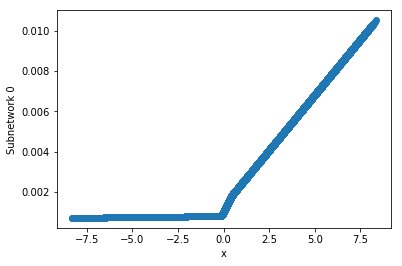

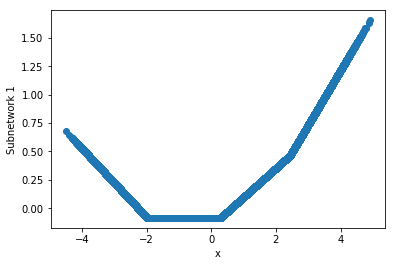

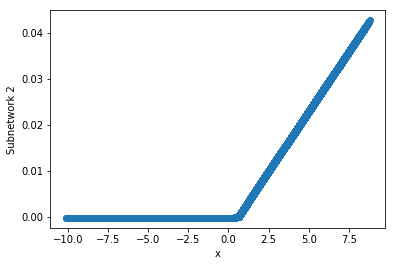

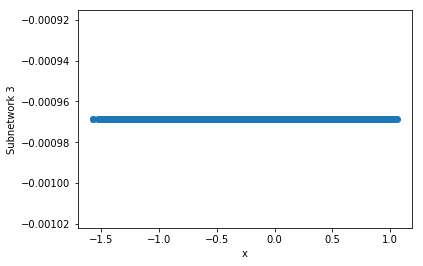

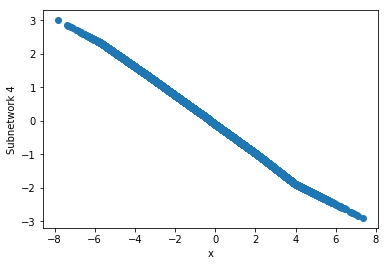

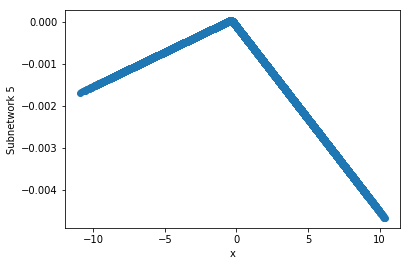

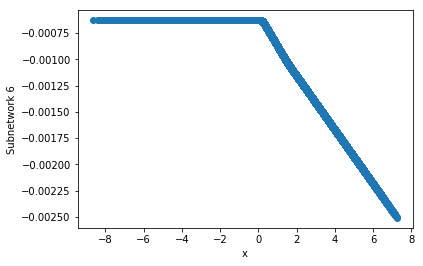

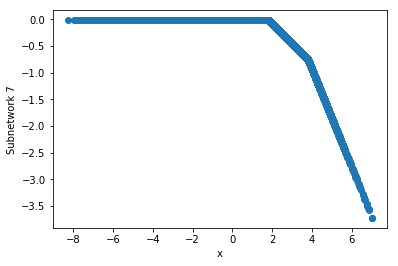

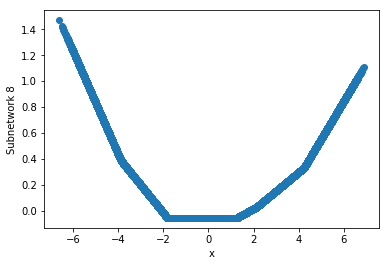

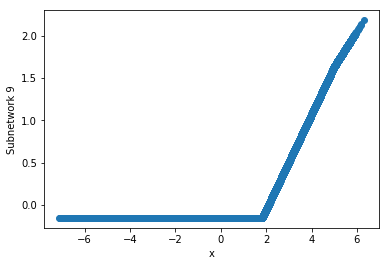

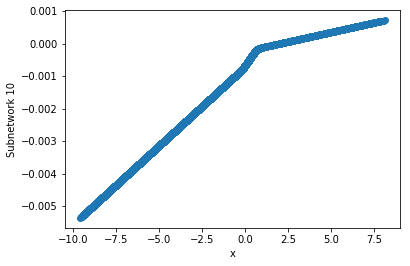

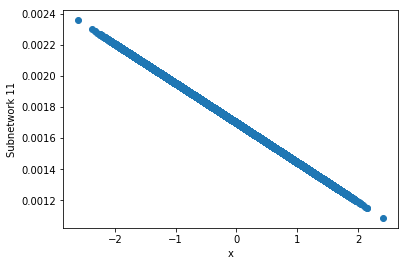

In [107]:
# Plot the ridge functions

Ridge_x = pd.read_csv(xnn_dir + "ridge_x_" + label + ".csv")
Ridge_y = pd.read_csv(xnn_dir + "ridge_y_" + label + ".csv")
Ridge_y = Ridge_y.applymap(lambda x: eval(x)[0])

Ridge_x.to_csv(xnn_dir + 'Results_simulation_Ridge_x_values.csv', index=False)
Ridge_y.to_csv(xnn_dir + 'Results_simulation_Ridge_y_values.csv', index=False)

for row_num in range(Ridge_y.shape[0]):
    plt.plot(Ridge_x.iloc[row_num,:], Ridge_y.iloc[row_num,:], 'o')
    plt.xlabel("x")
    plt.ylabel("Subnetwork " + str(row_num))
    plt.show()

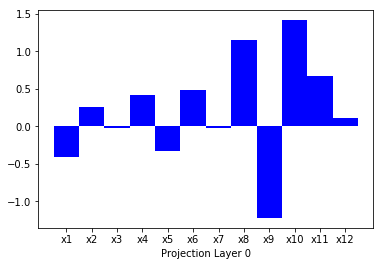

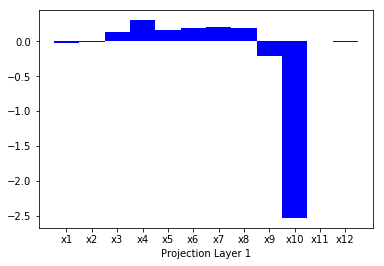

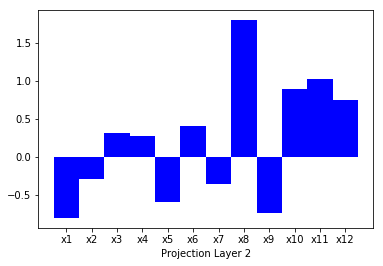

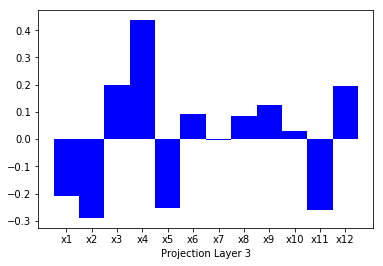

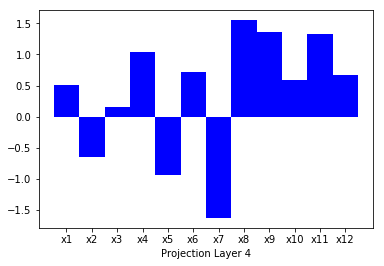

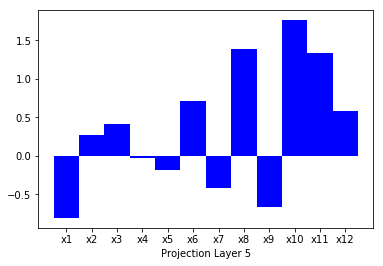

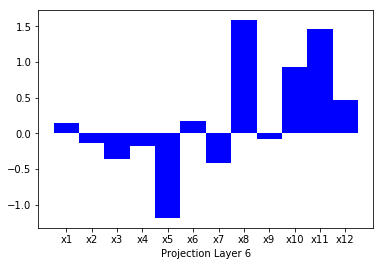

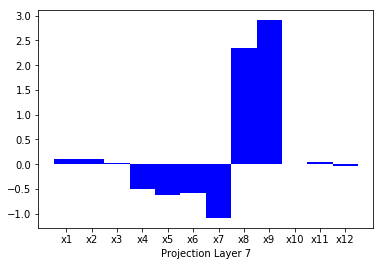

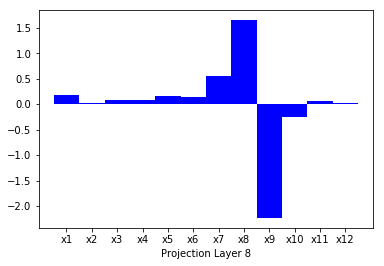

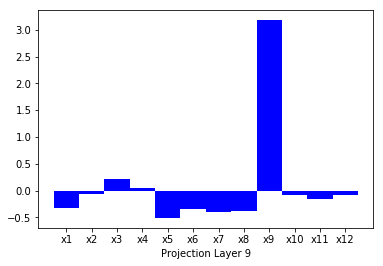

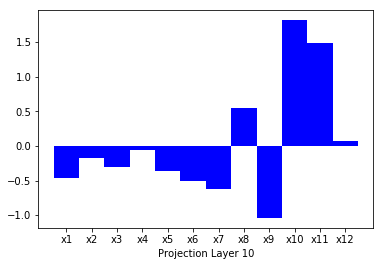

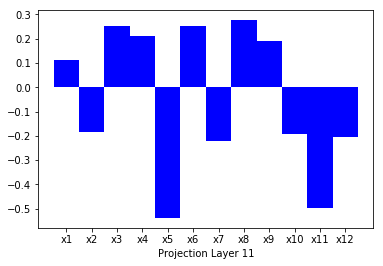

In [108]:
# Plot the projection layers

WP = pd.read_csv(xnn_dir + "wp_" + label + ".csv")

x = list(map(lambda x: 'x' + str(x+1), range(len(WP))))

WP.to_csv(xnn_dir + "Results_simulation_projection_layer.csv", index=False)

titles = ["Projection Layer " + str(ii) for ii in range(len(WP))]

for ind in range(len(WP)):
    plt.bar(x, WP.iloc[ind,:], 1, color="blue")
    plt.xlabel(titles[ind])
    plt.ylabel("")
    plt.show()

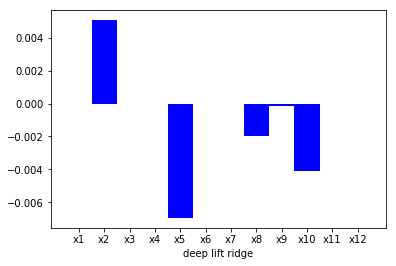

In [119]:
# Plot the deep lift score from the ridge function

Scores = pd.read_csv(xnn_dir + "scores_" + label + ".csv")

# Print the scores
x = list(map(lambda x: 'x' + str(x+1), range(Scores.shape[1])))

titles = ["layerwise average input", "layerwise average ridge",
          "layerwise average input 2", "layerwise average ridge 2",
          "shap input", "deep lift input", "deep lift ridge"]



ind = 6
Scores.iloc[ind,:].to_csv(xnn_dir + "Results_deep_lift_ridge_function_scores.csv")
plt.bar(x, Scores.iloc[ind,:], 1, color="blue")
plt.xlabel(titles[ind])
plt.ylabel("")
plt.show()

In [120]:
Scores

,0,1,2,3,4,5,6,7,8,9,10,11
0,3.029803e-01,-0.323992,-0.057721,8.997789e-02,-0.077721,3.295981e-01,1.082139e-02,0.066356,-0.886939,0.077898,4.067752e-01,9.349069e-02
1,-1.124525e-01,-0.226173,-0.045324,-3.882973e-02,1.339034,-9.924726e-03,-2.299528e-05,-0.161834,-0.273332,-0.374346,-1.500551e-04,-6.504876e-02
2,3.101209e-01,-0.313757,-0.058247,8.722608e-02,-0.079163,3.266211e-01,1.107037e-02,0.064474,-0.889215,0.044755,3.939124e-01,9.392185e-02
3,-1.144953e-01,-0.250808,-0.046203,-3.953600e-02,1.320565,-1.010803e-02,-2.235468e-05,-0.157816,-0.266499,-0.376839,-1.520441e-04,-6.623910e-02
4,3.314474e-04,-0.002002,-0.000672,-4.033371e-03,-0.000865,7.349718e-03,4.065921e-03,-0.001469,0.005076,0.000046,-2.194206e-02,-1.715109e-02
5,-5.482720e-02,0.001246,-0.035558,3.894494e-02,-0.008822,-3.307826e-03,-1.099732e-02,0.192044,-0.015878,-0.077889,-1.216077e-02,-2.094765e-02
6,7.352885e-07,0.005072,0.000001,-2.677721e-09,-0.006957,1.248657e-07,-4.312158e-08,-0.001984,-0.000171,-0.004115,9.170189e-08,6.385360e-08


In [121]:
TEST.columns

Index(['Unnamed: 0', 'binary1', 'binary2', 'ctrl_class1', 'ctrl_class2',
       'fold', 'intercept', 'latent_no_noise', 'latent_with_noise',
       'logistic_noise', 'outcome', 'outcome_no_noise', 'prot_class1',
       'prot_class2', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4',
       'fried1_std', 'fried2_std', 'fried3_std', 'fried4_std', 'fried5_std',
       'probability', 'binary1_Shapley_score', 'binary2_Shapley_score',
       'cat1_0_Shapley_score', 'cat1_1_Shapley_score', 'cat1_2_Shapley_score',
       'cat1_3_Shapley_score', 'cat1_4_Shapley_score',
       'fried1_std_Shapley_score', 'fried2_std_Shapley_score',
       'fried3_std_Shapley_score', 'fried4_std_Shapley_score',
       'fried5_std_Shapley_score', 'Intercept_Shapley_score'],
      dtype='object')

In [122]:
# Rename the test prediction and shapley columns
TEST.iloc[0:4,]
TEST = TEST.rename(columns={"0": "probability", 
                            "1": Feature_names[0]+"_Shapley_score",
                            "2": Feature_names[1]+"_Shapley_score",
                            "3": Feature_names[2]+"_Shapley_score",
                            "4": Feature_names[3]+"_Shapley_score",
                            "5": Feature_names[4]+"_Shapley_score",
                            "6": Feature_names[5]+"_Shapley_score", 
                            "7": Feature_names[6]+"_Shapley_score",
                            "8": Feature_names[7]+"_Shapley_score",
                            "9": Feature_names[8]+"_Shapley_score",
                            "10": Feature_names[9]+"_Shapley_score",
                            "11": Feature_names[10]+"_Shapley_score",
                            "12": Feature_names[11]+"_Shapley_score",
                            "13": "Intercept_Shapley_score"})
#Feature_names

In [123]:
# Save the results

TEST.columns

TEST.to_csv(xnn_dir + "Results_simulation_test_set.csv", index=False)